In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import shap
from shap import KernelExplainer
from sklearn import preprocessing


In [2]:
def read_data(filename):
    f = pd.read_csv(filename)

    d = f.loc[:, 'Solvent':'catalyst']  
    encoder = preprocessing.OneHotEncoder()
    encoder.fit(d)
    encoded = encoder.transform(d).toarray()
    print(encoded[0])

   
    del f['Solvent']
    del f['catalyst']


    new_feature_names = [
        'Deionized_Water', 'Ethanol', 'Ethylene_glycol', 'Methanol', 'Acetic_Acid', 
        'Ethylenediamine', 'Hydrogen_Peroxide', 'NONE']
    for i in range(encoded.shape[1]):
        f.insert(5 + i, new_feature_names[i], encoded[:, i])

    print(f)
    f.dropna(inplace=True)


    X = f.loc[:, 'Time/h':'catalystamount/mg']
    xnames = X.columns
    Y = f['INT']

    print("'processed_features.csv' and 'processed_target.csv'")
    print(X.shape)
    print(Y.shape)

    return X, Y, xnames


X, Y, xnames = read_data('C:/Users/Hu/work1/step1/HWW.csv')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=10) 
print("X_train's shape is", X_train.shape,"; y_train's shape is", y_train.shape)
print("X_test's shape is", X_test.shape,"; y_test's shape is",y_test.shape)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train) 
X_test_stand = scaler.transform(X_test) 

[1. 0. 0. 0. 1. 0. 0. 0.]
    Time/h  Tem/℃  PG/mg  OPD/mg  Solventamount/ml  Deionized_Water  Ethanol  \
0        8    180   6.25    6.25                25              1.0      0.0   
1        8    180   6.25    6.25                25              0.0      1.0   
2        8    180   0.00    6.25                25              0.0      1.0   
3       12    200   0.20    5.00                25              0.0      1.0   
4       12    200   0.00    5.00                25              0.0      1.0   
..     ...    ...    ...     ...               ...              ...      ...   
73       4    180   0.00   15.00                25              1.0      0.0   
74       4    120   0.00   15.00                25              1.0      0.0   
75       8    120   0.00   20.00                50              0.0      1.0   
76       8    120   0.00   15.00                50              0.0      1.0   
77       8    120   0.00   10.00                50              0.0      1.0   

    Ethylene_

In [3]:
def build_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)  
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.01),
        loss='mse',
        metrics=['mae']
    )
    return model

model = build_model()
model.summary()

D:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(
    X_train, y_train,
    epochs=400,
    batch_size=5,
    validation_split=0.2,
    verbose=0
)


y_train_hat = model.predict(X_train).flatten()
y_test_hat = model.predict(X_test).flatten()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


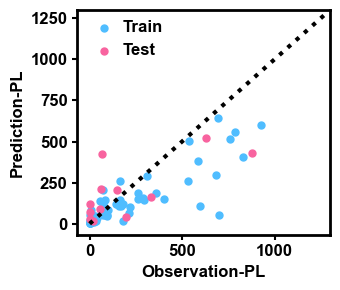

In [8]:
fontsize = 12

plt.figure(figsize=(3.5, 3))


plt.style.use('default')


plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rcParams['font.family'] = "Arial"
plt.rcParams['font.weight'] = 'bold'


plt.tick_params(axis='both', which='major', width=1.5)


a = plt.scatter(y_train, y_train_hat, s=25, c='#4FBDFF')

plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k:', lw=3)  

plt.xlabel('Observation-PL', fontsize=fontsize, fontweight='bold')  
plt.ylabel('Prediction-PL', fontsize=fontsize, fontweight='bold') 


b = plt.scatter(y_test, y_test_hat, s=25, c='#F8639F')


plt.xlim(right=1300)


plt.ylim(top=1300)


plt.legend((a, b), ('Train', 'Test'), fontsize=fontsize, handletextpad=0.1, borderpad=0.1, frameon=False, loc='best')


for spine in plt.gca().spines.values():
    spine.set_linewidth(2) 


plt.tight_layout()


plt.savefig('ANN.png', dpi=300, bbox_inches='tight')


plt.show()
